# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns
from scipy import stats
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to /root/nltk_data...
[nltk_data]   Package abc is already up-to-date!


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# inspect the first row
df.iloc[0]['title']

'using pixiedust for fast, flexible, and easier data analysis and experimentation'

In [3]:
# show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
print(df_content.iloc[0])

doc_body           Skip navigation Sign in SearchLoading...\r\n\r...
doc_description    Detect bad readings in real time using Python ...
doc_full_name      Detect Malfunctioning IoT Sensors with Streami...
doc_status                                                      Live
article_id                                                         0
Name: 0, dtype: object


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# group by email
def group_by_title(df, column = "email"):
    """group the user-item interactions dataframe by column.
    
        Args:
            df (Dataframe): a dataframe object 
            column (string): column to group by 
            per column.
            
        Returns:
            Dataframe: dataframe of user article interaction counts sorted in descending order
        
        """
    
    df_title_counts = df.groupby(['email']).size().reset_index(name='counts')
    df_title_counts = df_title_counts.sort_values(by=['counts'], ascending=False)
    return df_title_counts

user_article_counts = group_by_title(df)
user_article_counts.head()

,email,counts
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [6]:
print( "The number of articles are {} and users interacted {} times these articles" \
      .format(user_article_counts.shape[0], user_article_counts["counts"].sum()))

The number of articles are 5148 and users interacted 45976 times these articles


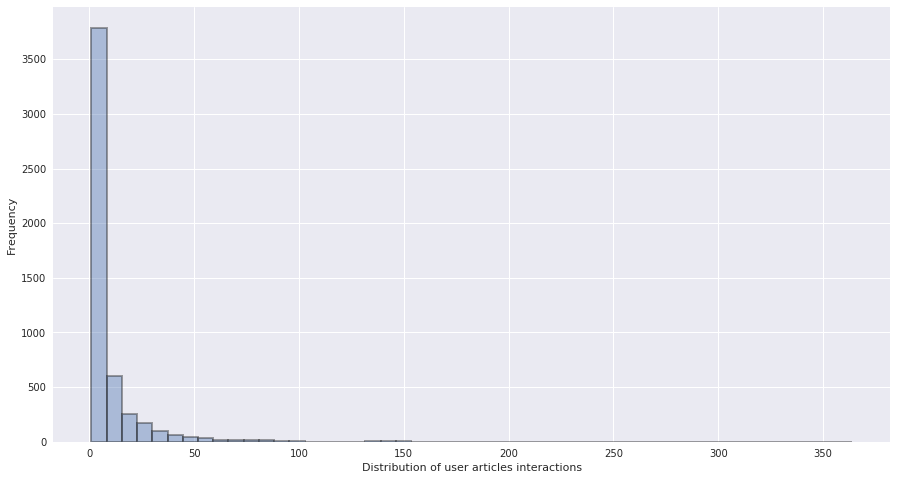

In [7]:
def histogram (df, column = "counts", title="Distribution of user articles interactions"):
    """Create a distribution of user article interactions.
    
        Args:
            df (Dataframe): a dataframe object 
            column (string): column that holds article counts 
            title (string): the title of the distribution chart
            
        Returns:
            figure: a matplotlib distribution figure of article counts
        
        """
    
    sns.set(color_codes=True)
    plt.figure(figsize=(15,8))
    sns.distplot(df[column], kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
    plt.xlabel(title)
    plt.ylabel('Frequency');
histogram(user_article_counts)

In [8]:
# fill in the median and maximum number of user_article interactios below
median_val = user_article_counts["counts"].median() # 50% of individuals interact with 3 number of articles or fewer.
max_views_by_user = user_article_counts["counts"].max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# find and explore duplicate articles
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


In [10]:
# get duplicate articles
df_content[df_content.duplicated(subset="article_id")]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
# remove any rows that have the same article_id - only keep the first
df_content_clean = df_content.drop_duplicates(subset="article_id")

In [12]:
assert df_content_clean.shape[0] + 5 == df_content.shape[0]

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
# the number of unique articles that have an interaction with a user.
df.article_id.nunique()

714

In [14]:
# the number of unique articles in the dataset (whether they have any interactions or not).
df_content_clean.article_id.nunique()

1051

In [15]:
# the number of unique users in the dataset. (excluding null values) 
df.email.nunique()

5148

In [16]:
# the number of user-article interactions in the dataset.
df.shape[0]

45993

In [17]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
# most viewed article
article_counts = df.groupby(['article_id']).count()
article_counts['email'].max()

937

In [19]:
article_counts.sort_values("email", ascending=False).iloc[0,:]

title    937
email    937
Name: 1429.0, dtype: int64

In [20]:
most_viewed_article_id = "1429.0" # the most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # the most viewed article in the dataset was viewed how many times?

In [21]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [23]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [24]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby(['article_id', 'title']).size()\
                        .reset_index(name='counts').sort_values('counts', ascending=False)[:n].title.tolist()
    return  top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    top_articles = df.groupby("article_id").count()["title"].sort_values(ascending=False).index[:n].astype('str')
    return top_articles.tolist() # Return the top article ids

In [25]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # unstack the user-item interaction dataframe
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack()
    
    # fill missing values with 0
    user_item = user_item.fillna(0)
    
    # convert int
    user_item = user_item.astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similr = user_item.loc[user_id,:].dot(user_item.T)
    
    # sort by similarity
    user_similr = user_similr.sort_values(ascending=False)
        
    # create list of just the ids
    # remove the own user's id
    most_similar_users = user_similr.loc[~(user_similr.index==user_id)].index.values.tolist()
    
    return most_similar_users # return a list of the users in order from most to least similar


In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    
    # select articles with the same article_id and drop duplicates
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user_idx = user_item.loc[user_id, :] #get all articles for this user id
    article_ids = user_idx[user_idx == 1].index.values.astype('str').tolist() #get articles user interacted with
    article_names = get_article_names(article_ids) # get article names
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    most_similar_users = find_similar_users(user_id) # get most similar users
    user_article_ids = set(get_user_articles(user_id)[0]) # get article ids 
    
    recs = []
    # create recommendations for this user
    for user_neighb in most_similar_users:
        neighb_article_ids = set(get_user_articles(user_neighb)[0])
        recs += list(set(neighb_article_ids) - set(user_article_ids))
        if len(recs) > m:
            break
    
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze accident reports on amazon emr spark',
 'accelerate your workflow with dsx',
 'challenges in deep learning',
 'working with db2 warehouse on cloud in data science experience',
 'brunel interactive visualizations in jupyter notebooks',
 'machine learning exercises in python, part 1',
 'this week in data science (april 25, 2017)',
 'data science platforms are on the rise and ibm is leading the way',
 'machine learning for the enterprise',
 'overlapping co-cluster recommendation algorithm (ocular)']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    colName = ['neighbor_id', 'similarity', 'num_interactions'] # column names
    neighbors_df  = pd.DataFrame(columns= colName) # create dataframe to hold top users
        
    # populate the dataframe
    for id in user_item.index.values:
        if id != user_id:
            neighbor_id = id
            
            # get user to user similarity
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[id].T).values[0]
            
            # get number of interactions for user ot article
            num_interactions = user_item.loc[id].values.sum()
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    return neighbors_df # return the dataframe


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # Your code here
    # get similar users
    neighbours = get_top_sorted_users(user_id)
    top_similar_users = neighbours['neighbor_id'].values.tolist()
    recs = []  # recommended article Id's
    
    # get articles read by the user
    user_article_ids = list(set(get_user_articles(user_id)[0]))
    
    for neighbour_id in top_similar_users:
        recs += df[df['user_id'] == neighbour_id]['article_id'].values.tolist()
    
    recs = list(set(recs))
    
    # selecting articles not seen by User_id
    recs = [ x for x in recs if x not in user_article_ids]
    
    recs_df = df[df.article_id.isin(recs)][['article_id', 'title']].drop_duplicates().head(m) 
    recs = recs_df['article_id'].values.tolist() # get ids
    rec_names = recs_df['title'].values.tolist() # get title
    
    
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1314.0, 1429.0, 1338.0, 1276.0, 1432.0, 593.0, 1185.0, 993.0, 14.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'upload files to ibm data science experience using the command line', 'classify tumors with machine learning', 'configuring the apache spark sql context', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id # Find the 10th most similar user to user 131

In [37]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

I will choose ```user_user_recs_part2```. It's a good start to recommend articles from the most active users and make sure these articles are the most interacted articles as well. For new users, we can ask them about their preferences, then recommend top articles that are matching this preference. Once we have more data on them, we can move to matrix factorization. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
def tokenize(x):
    '''
    Tokenize a string into words. 
    
    Args:
        x(string): string to tokezine.
            
    Returns:
        (list): list of lemmatized words
    '''
    # get stop words
    stop_words = (set(stopwords.words('english')) | set(nltk.corpus.abc.words()))
    tokens = word_tokenize(x) # split each article title into individual words
    lemmatizer = WordNetLemmatizer()
    clean_tokens=[]
    for token in tokens:
        #clean each token from whitespace and punctuation, and conver to root word
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    filtered = [word for word in clean_tokens if word not in stop_words and word.isalpha()]
    return filtered

In [41]:
def make_content_recs(data_id, user_id=True, m=10, df=df):
    '''
    This recommender goes through each article title and nltk library to finds the most common words
    (related to content) throughout all the articles.
    
    The recommender will look at the sums of words in the title of each article 
    and based on the number of matches and popularity of an article.
       
    Args:
        data_id (str) - id of either user or article
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    Returns:
        recs (list) - list of article ids that are recommended
        rec_names (list) - list of article names that are recommended   
    '''
    
    if(user_id):
        user_id = data_id
        try:
            # get past articles read by the user
            article_ids, _ = get_user_articles(user_id)
        except KeyError: # user does not exist
            print('User Doesn\'t Exist, Recommending Top Articles')
            recs = get_top_article_ids(m)
            return recs, get_article_names(recs)
    
    else:
        article_ids = data_id
        
    title_data = df.drop_duplicates(subset='article_id') #drop duplicates 
    titles = title_data[title_data.article_id.isin(list(map(float, article_ids)))].title # get article titles
    
    #tokenize the words in each article title
    title_words=[]
    tokenized = tokenize(titles.str.cat(sep=' '))
    title_words.extend(tokenized)
    
    #find the highest occuring words
    common_words = pd.value_counts(title_words).sort_values(ascending=False)[:10].index

    top_matches={}
    # measure of similarity: count number of occurences of each common word in other article titles
    for word in common_words:
        word_count = pd.Series(title_data.title.str.count(word).fillna(0)) #gets occurences of each word in title
        top_matches[word] = word_count
    
    # most common words
    top_matches = pd.DataFrame(top_matches) 
    top_matches['top_matches'] = top_matches.sum(axis=1)
    top_matches['article_id'] = title_data.article_id.astype(float)
    
    # get most interacted with articles
    article_occurences = pd.DataFrame({'occurences':df.article_id.value_counts()})

    # sort matches by most popular articles
    top_matches = top_matches.merge(article_occurences, left_on='article_id', right_index=True)
    top_matches.sort_values(['top_matches', 'occurences'], ascending=False, inplace=True)    
    
    # drop already read articles
    recs_df = top_matches[~top_matches.article_id.isin(list(map(float, article_ids)))]
    
    # get rec id and names
    recs = recs_df.article_id[:m].values.astype(str)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.


This content based recommender scans through previously interacted articles. The nltk library finds the most common words in the titles of each article.

Based on these most common words, the recommender looks at the sums of words relevant words in the title of each article, and based on the number of matches in the titles as well as the general popularity of the article it gives back the best recommendations.

If the user has not read any articles yet, then we can't really give any content based recommendations, and just return back some of the most popular articles.

There is a lot of potential improvement and optimization for this recommender. For example one could construct a custom NLTK corpus which would filter out article words. Currently I use a combination of a couple standard NLTK corpora. Furthermore, If df_content had information for all articles we could expand this recommender to look through not only the title but also the body of the articles.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments. Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

We are using the NLTK library to search for articles with similar keywords. If the user has no history yet, then no content-based recommendation is given, and we will return some of the most popular articles.

We can improve this further by looking at similar keywords but semantically not just the exact keyword. Also, if the user doesn't like a specific article because it has deep learning contents, it doesn't mean that he or she will disklike every article with deep learning content. It will be interesting to augment content-based recommendation with some ML algorithm that can handle such situations. 

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
# make recommendations for a brand new user
make_content_recs('0.0', user_id=True)

User Doesn't Exist, Recommending Top Articles


(['1429.0',
  '1330.0',
  '1431.0',
  '1427.0',
  '1364.0',
  '1314.0',
  '1293.0',
  '1170.0',
  '1162.0',
  '1304.0'],
 ['healthcare python streaming application demo',
  'use deep learning for image classification',
  'apache spark lab, part 1: basic concepts',
  'predicting churn with the spss random tree algorithm',
  'analyze energy consumption in buildings',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'gosales transactions for logistic regression model',
  'insights from new york car accident reports',
  'finding optimal locations of new store using decision optimization'])

In [43]:
# make a recommendations for a user who only has interacted with article id '1427.0'
make_content_recs(['1427.0'], user_id=False)

(array(['1159.0', '390.0', '1332.0', '1324.0', '241.0', '1422.0', '969.0',
        '729.0', '14.0', '254.0'], 
       dtype='<U32'),
 ['got zip code data? prep it for analytics. – ibm watson data lab – medium',
  'ibm watson facebook posts for 2015',
  'intents & examples for ibm watson conversation',
  'use r dataframes & ibm watson natural language understanding',
  'pixiedust 1.0 is here! – ibm watson data lab',
  'i am not a data scientist – ibm watson data lab',
  'flightpredict ii: the sequel  – ibm watson data lab',
  'introducing ibm watson studio ',
  'apple, ibm add machine learning to partnership with watson-core ml coupling',
  'analyze facebook data using ibm watson and watson studio'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)  # use the built in to get the three matrices

In [47]:
print("Number of Nans in the users to item interactions matrix is: {}".format(np.isnan(user_item_matrix).sum().sum()))
print("Number of Nans in the users to latent features matrix is: {}".format(np.isnan(u).sum().sum()))
print("Number of Nans in the segma matrix is: {}".format(np.isnan(s).sum().sum()))
print("Number of Nans in the items to latent features matrix is: {}".format(np.isnan(vt).sum().sum()))

Number of Nans in the users to item interactions matrix is: 0
Number of Nans in the users to latent features matrix is: 0
Number of Nans in the segma matrix is: 0
Number of Nans in the items to latent features matrix is: 0


**Provide your response here.**



We can use Singular Value Decomposition because **there are no missing values (NANs) in our data.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

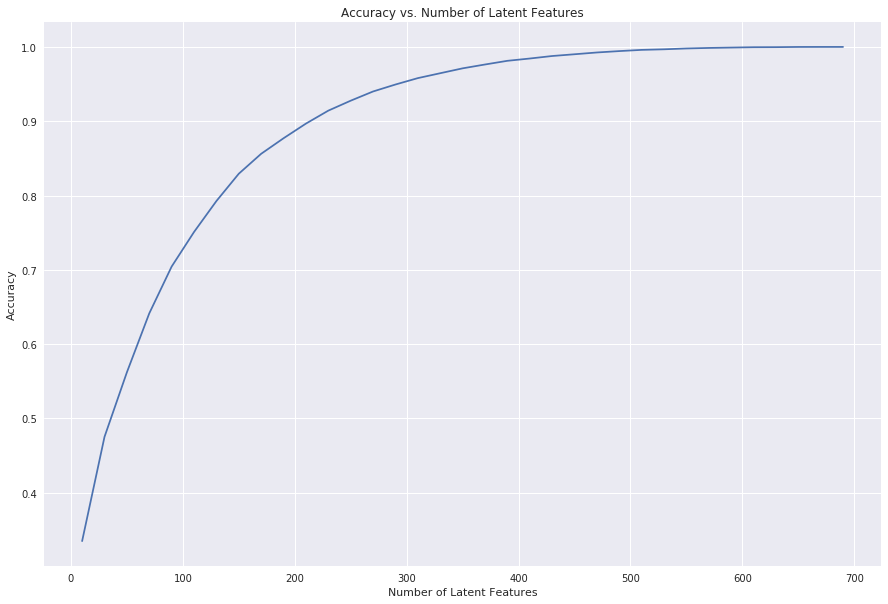

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize=(15,10))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [49]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    # create user item matrix for the train dataset
    user_item_train = create_user_item_matrix(df_train)
    
    # create the test dataset
    user_item_test = create_user_item_matrix(df_test)
    
    # get the ids of the train dataset and test dataset
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    
    # get shared rows
    shared_rows = train_idx.intersection(test_idx)
    
    # get columns in train and test datasets
    train_arts = set(user_item_train.columns)
    test_arts = set(user_item_test.columns)
    
    # get shared columns
    shared_cols = train_arts.intersection(test_arts)
    
    # Creating new user-item matrix for tets with common values
    user_item_test = user_item_test.ix[shared_rows, shared_cols]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [50]:
print(user_item_test.shape[0])
print(len(test_idx) - user_item_test.shape[0])
print(user_item_test.shape[1])
print(len(test_arts) - user_item_test.shape[1])

20
662
574
0


In [51]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

# this should be article not movies. it was bugging me and wasted some time on it
t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [52]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [53]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
def svd_algorithm(u_train, s_train, vt_train):
    """ Return the results of the svd algorithm.
    
        Args:
            u_train (np.array): user item interaction matrix  
            s_train (np.array): sigma matrix
            vt_train (np.array): v transpose matrix
            
        Returns:
            Dataframe: dataframe of user article interaction counts sorted in descending order
        
        """

    num_latent_feats = np.arange(10,700+10,20)
    sum_errs_train = []
    sum_errs_test = []
    all_errs = []

    for k in num_latent_feats:
        # ge u_test and vt_test
        row_idxs = user_item_train.index.isin(test_idx)
        col_idxs = user_item_train.columns.isin(test_arts)
        u_test = u_train[row_idxs, :]
        vt_test = vt_train[:, col_idxs]
        
        # split data 
        s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
        u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]

        # dot product:
        user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
        user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
        all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test))) \
                             /(user_item_test.shape[0]*user_item_test.shape[1])))

        # calculate the error of each prediction
        diffs_train = np.subtract(user_item_train, user_item_train_preds)
        diffs_test = np.subtract(user_item_test, user_item_test_preds)

        # get total Error
        err_train = np.sum(np.sum(np.abs(diffs_train)))
        err_test = np.sum(np.sum(np.abs(diffs_test)))

        sum_errs_train.append(err_train)
        sum_errs_test.append(err_test)
        
    # plot accuracy for train and test vs number of latent features
    plt.figure(figsize=(15,10))

    # latent features and training
    plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train', color='darkred')

    # latent features and testing
    plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test', color='darkblue')

    plt.plot(num_latent_feats, all_errs, label='Total Error', color = "orange")
    plt.xlabel('Number of Latent Features')
    plt.ylabel('Accuracy')
    plt.legend();

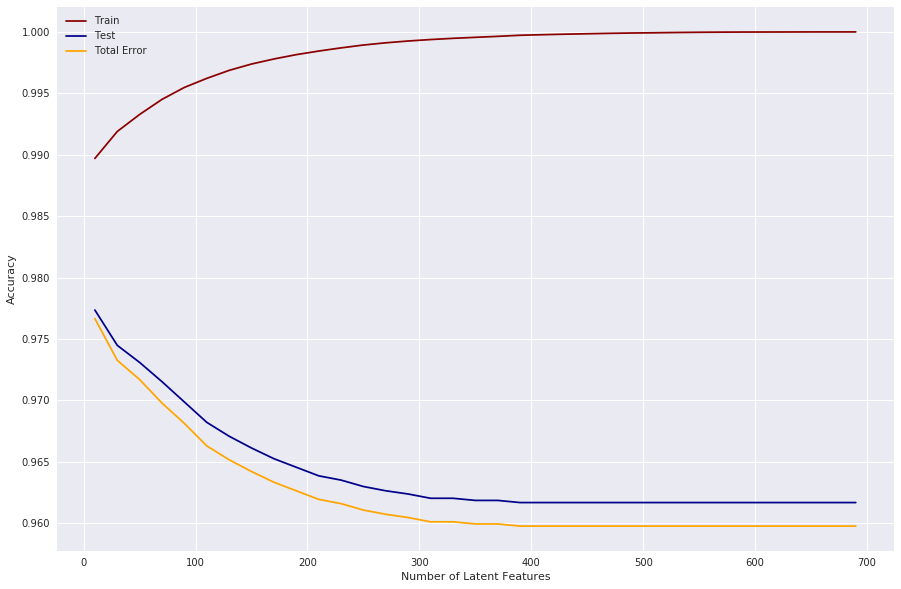

In [54]:
# call the svd algorithm
svd_algorithm(u_train, s_train, vt_train)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

- Test accuracy decreases as the number of latent features increases for the testing dataset.
- In this project, only 20 users had records of old interactions.
- To solve the cold-start problem, we can deploy rank based recommendation method or content based recommendation.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0